## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)

In [6]:
# construct the function interface of finding chessboard.
def ChessboardPoints(img,grid=(9,6)):  
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((grid[0]*grid[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:grid[0], 0:grid[1]].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    
    return objpoints,imgpoints

In [7]:
# Imread chessboard images to find points
#img =cv2.imread('./camera_cal/calibration3.jpg')
img = mpimg.imread('./camera_cal/calibration3.jpg')
objpoints,imgpoints = ChessboardPoints(img,grid=(9,6))

## 2.Apply a distortion correction to raw images.

In [8]:
# Define a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0]) 
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# imread test images for calibration ,undistortion
img_test0 = mpimg.imread('./camera_cal/calibration2.jpg')
undistorted0 = cal_undistort(img_test0, objpoints, imgpoints)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test0)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted0)
ax2.set_title('Undistorted Image', fontsize=15)

plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.)

In [9]:
img_test = mpimg.imread('./test_images/test1.jpg')
undistorted = cal_undistort(img_test, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=15)
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.)

In [10]:
def M_Minv():
    src = np.float32([[(180,719),(595,450),(685,450),(1120,719)]])
    dst = np.float32([[(310,719),(310,0),(960,0),(960,719)]])
    
    '''
    # Choose offset from image corners to plot detected corners
    offset = 100
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    '''                             
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    return M,Minv

#img_size =(undistorted.shape[1], undistorted.shape[0])
M,Minv = M_Minv()
#undist_warped = cv2.warpPerspective(undistorted, M, img_size)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [11]:
##applying sobel

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient,sobel_kernel,thresh):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'   
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
        abs_sobel = np.absolute(sobel)
    else:
        print('input error: orient should be x or y')
        
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return sxbinary


def mag_thresh(img, sobel_kernel, mag_thresh):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx **2 + sobely **2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
   
    return sxybinary
    
    
def dir_threshold(img, sobel_kernel, thresh):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelxy = np.sqrt(sobelx ** 2 +sobely **2)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #scaled_sobel = np.uint8(255 * abs_sobelxy/np.max(abs_sobelxy))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output

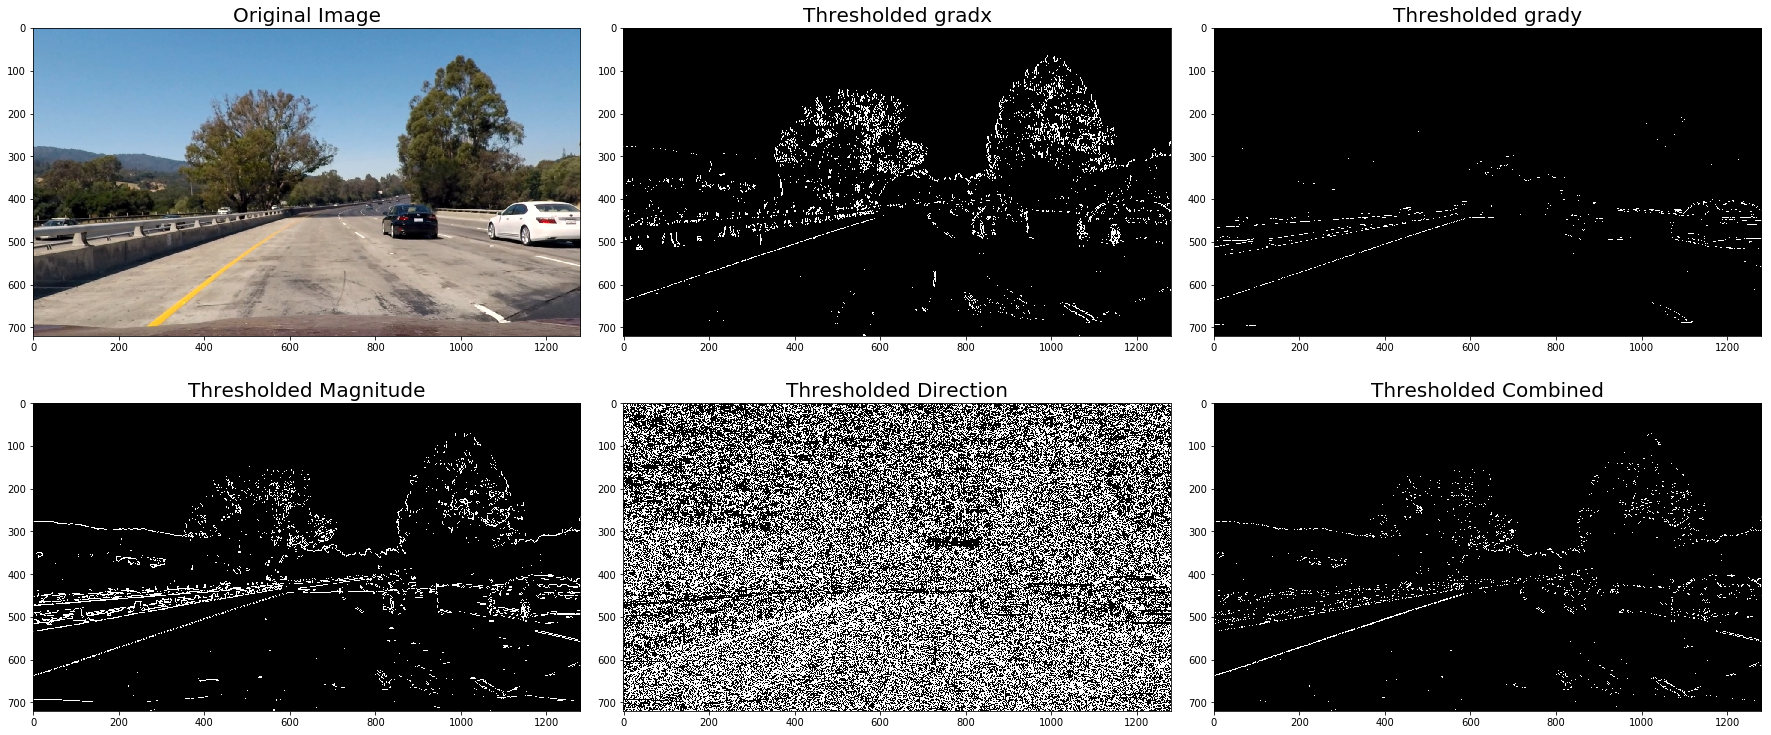

In [12]:
image = undistorted
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(28, 120))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(100, 150))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 120))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.6, 1.4))    
    
combined = np.zeros_like(dir_binary)    
combined[((gradx==1)&(grady==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# Run the function

# Plot the result
f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded gradx', fontsize=20)

ax3.imshow(grady, cmap='gray')
ax3.set_title('Thresholded grady', fontsize=20)

ax4.imshow(mag_binary, cmap='gray')
ax4.set_title('Thresholded Magnitude', fontsize=20)

ax5.imshow(dir_binary, cmap='gray')
ax5.set_title('Thresholded Direction', fontsize=20)

ax6.imshow(combined, cmap='gray')
ax6.set_title('Thresholded Combined', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

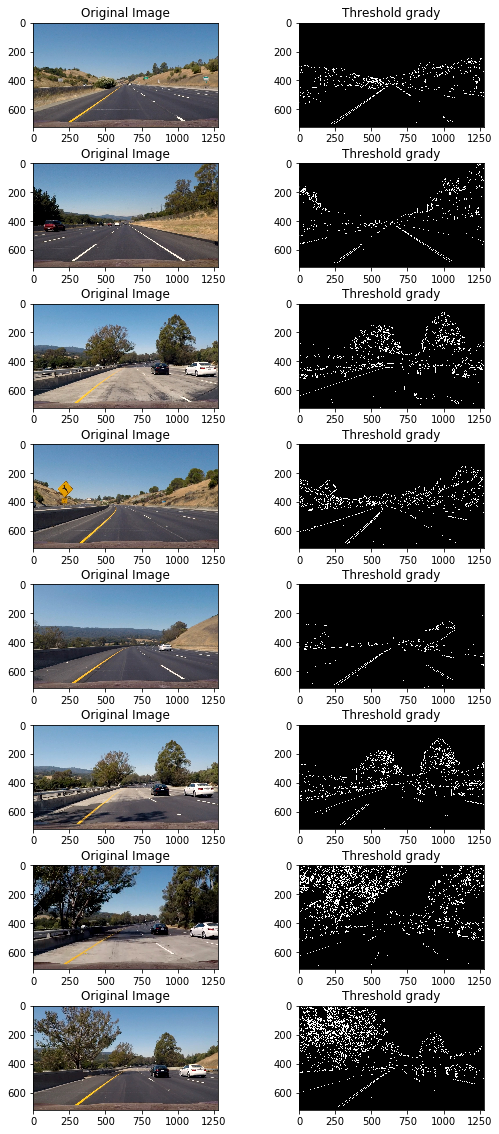

In [92]:
images = glob.glob('./test_images/*.jpg')

f, axs = plt.subplots(8,2, figsize=(15, 20))
#f.tight_layout()
f.subplots_adjust(hspace = .35, wspace=.01,left=.5, right=.99)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(28, 120))
    
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(100, 150))
    mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(50, 120))
    dir_binary = dir_threshold(undistorted, sobel_kernel=3, thresh=(0.6, 1.4)) 
    combined1 = np.zeros_like(gradx) 
    combined1[((gradx==1)|(grady==1))] = 1
    #combined[((gradx==1)&(grady==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined1[((gradx==1)|(grady==1)) & ((dir_binary == 1))] = 1
    
    #axs[i].axis('off')
    axs[2*i].imshow(img)
    axs[2*i].set_title('Original Image')
    axs[2*i+1].imshow(combined1,cmap='gray')
    axs[2*i+1].set_title('Threshold grady')
    
plt.show()

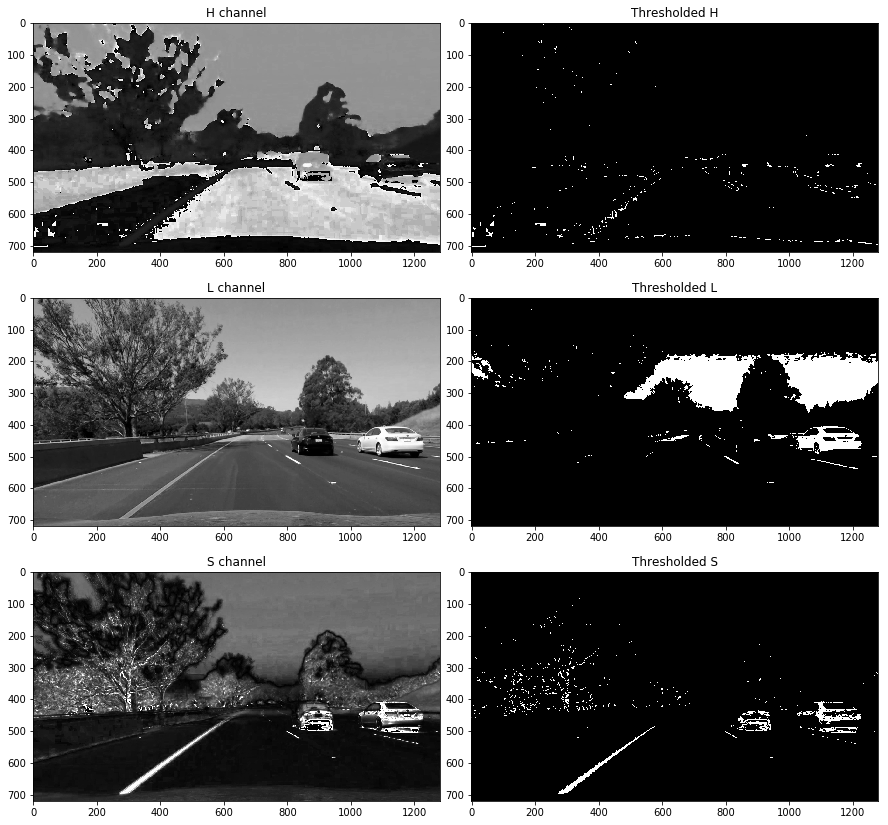

In [77]:
## Color transform
# Read in an image, you can also try test1.jpg or test4.jpg
#image = mpimg.imread('./test_images/test5.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, channel='s',thresh=(175,255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    if channel =='h':
        binary_output = np.zeros_like(h_channel)
        binary_output[(h_channel >= thresh[0]) & (h_channel <= thresh[1])] = 1
    elif channel=='l':
        binary_output = np.zeros_like(l_channel)
        binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    elif channel =='s':
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    else:
        print("channel should be h,l or s.")
        
    # 3) Return a binary image of threshold result
    return binary_output
 
image = undistorted
h_binary = hls_select(image,channel='h', thresh=(175, 255))
l_binary = hls_select(image,channel='l', thresh=(175, 255))
s_binary = hls_select(image,channel='s', thresh=(175, 255))

gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 150))
grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(100, 150))
mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(50, 120))
dir_binary = dir_threshold(undistorted, sobel_kernel=3, thresh=(0.6, 1.4)) 

combined2 = np.zeros_like(gradx)    
#combined1[((gradx==1)|(s_binary==1))] = 1
#combined1[((gradx == 1) & (mag_binary == 1)) | ((dir_binary == 1) & (s_binary == 1))]=1
#combined1[((gradx==1)&(s_binary==1)) | ((mag_binary == 1) & (dir_binary == 1))]=1
combined2[((gradx==1)|(grady==1)) & ((dir_binary == 1))|(s_binary==1)] = 1

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# Plot the result
plt.imshow(image)

f, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(h_channel,cmap='gray')
ax1.set_title('H channel')
ax2.imshow(h_binary,cmap='gray')
ax2.set_title('Thresholded H')

ax3.imshow(l_channel,cmap='gray')
ax3.set_title('L channel')
ax4.imshow(l_binary,cmap='gray')
ax4.set_title('Thresholded L')

ax5.imshow(s_channel,cmap='gray')
ax5.set_title('S channel')
ax6.imshow(s_binary,cmap='gray')
ax6.set_title('Thresholded S')

plt.subplots_adjust(left=0.5, right=1, top=1.2, bottom=0.,wspace=0.03,hspace=0.2)

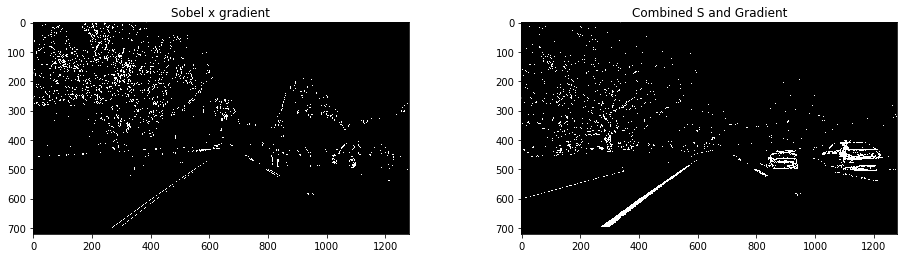

In [78]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Sobel x gradient')

ax2.imshow(combined2, cmap='gray')
ax2.set_title('Combined S and Gradient')

plt.subplots_adjust(left=0.5, right=1, top=1.2, bottom=0.,wspace=0.3,hspace=0.2)

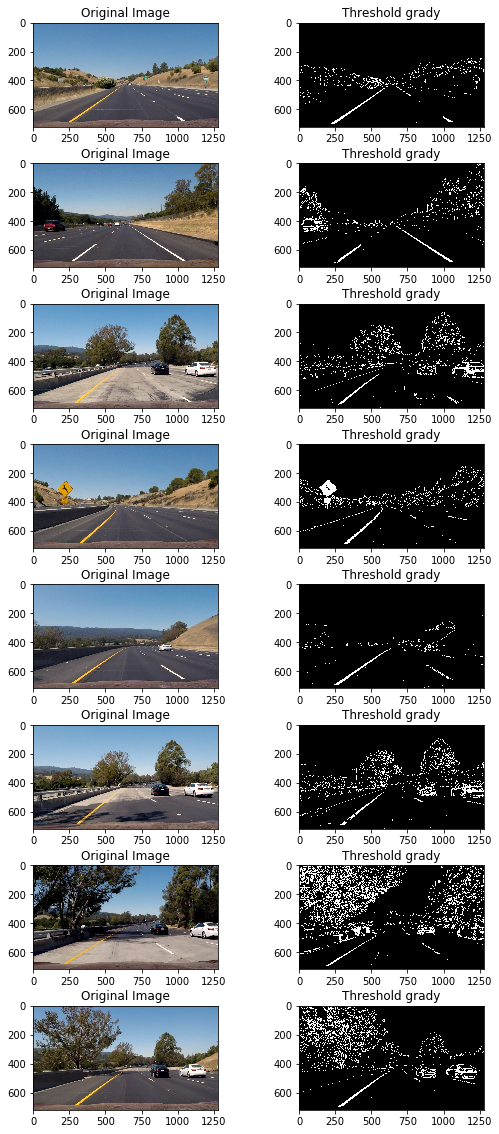

In [113]:
images = glob.glob('./test_images/*.jpg')

f, axs = plt.subplots(8,2, figsize=(15, 20))

f.subplots_adjust(hspace = .35, wspace=.01,left=.5, right=.99)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(28, 120))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(100, 150))
    mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(50, 120))
    dir_binary = dir_threshold(undistorted, sobel_kernel=3, thresh=(0.6, 1.4)) 
    s_binary = hls_select(undistorted,channel='s', thresh=(175, 255))
    
    combined2 = np.zeros_like(gradx)    
    #combined[((gradx==1)&(grady==1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined2[((gradx==1)|(s_binary==1))] = 1
    
    #combined2[((gradx==1)|(grady==1)) & ((dir_binary == 1))|(s_binary==1)] = 1
    #warped = cv2.warpPerspective(combined2, M,(combined2.shape[1],combined2.shape[0]), flags=cv2.INTER_LINEAR) 
    #axs[i].axis('off')
    axs[2*i].imshow(img,cmap='gray')
    axs[2*i].set_title('Original Image')
    axs[2*i+1].imshow(combined2,cmap='gray')
    axs[2*i+1].set_title('Threshold grady')
    
plt.show()

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [140]:
def warp(img):
    img_shape = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR) 
    return warped

# undistorted-> Color transform-> wraped
#warped = warped(combined2) #birds-eye view

In [152]:
def pipeline(img):

    # Distortion correction
    undist = cal_undistort(img,objpoints,imgpoints)
    #Get M/Minv
    M,Minv = M_Minv()
    #Thresh using sobel with absolute
    gradx = abs_sobel_thresh(undist, orient='x',sobel_kernel=3,thresh=(50,150))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=3, thresh=(100, 150))
    #mag_binary = mag_thresh(undist, sobel_kernel=3, mag_thresh=(50, 120)) 
    #Sobel direction
    dir_binary = dir_threshold(undist, sobel_kernel=3, thresh=(0.6, 1.4)) 
    #hls
    s_binary = hls_select(undist, thresh=(175, 255))
    #combine gradx and hls thresholds
    combined = np.zeros_like(dir_binary)    
    combined[((gradx==1)|(s_binary==1))] = 1
    #combined[((gradx==1)|(grady==1)) & ((dir_binary == 1))|(s_binary==1)] = 1
    #Perspective Transform
    warped = warp(combined)
    return warped, Minv

print('Done!')

Done!


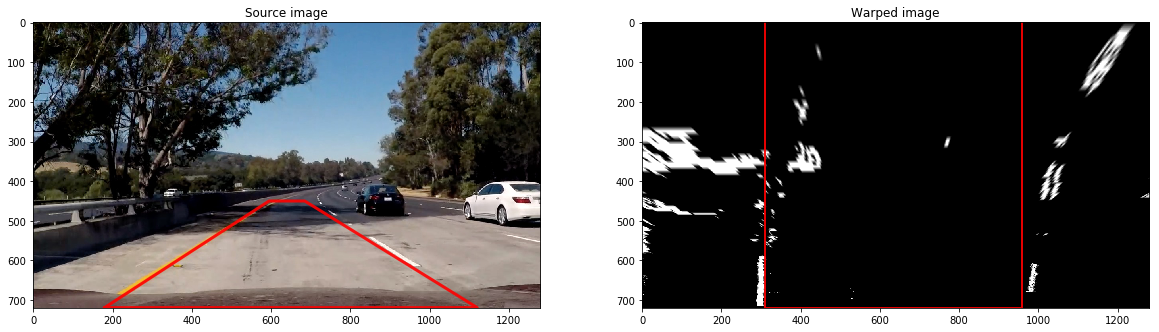

In [155]:

img = mpimg.imread('./test_images/test5.jpg')
warped,Minv = pipeline(img)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title('Source image')
#ax1.imshow(img)
ax1.imshow(img,cmap='gray')
x_list = [180, 1120, 685,595,180]
y_list = [719, 719, 450, 450,719]
ax1.plot(x_list, y_list, color='r',linewidth=3,alpha=0.9)

# src = np.float32([[(180,719),(595,450),(685,450),(1120,719)]])
# dst = np.float32([[(310,719),(310,0),(960,0),(960,719)]])

ax2.set_title('Warped image')
ax2.imshow(warped,cmap='gray')

x1_list=[310,310,960,960]
y1_list=[0,719,719,0]
ax2.plot(x1_list,y1_list,color='r',linewidth=2,alpha=0.9)


Done!


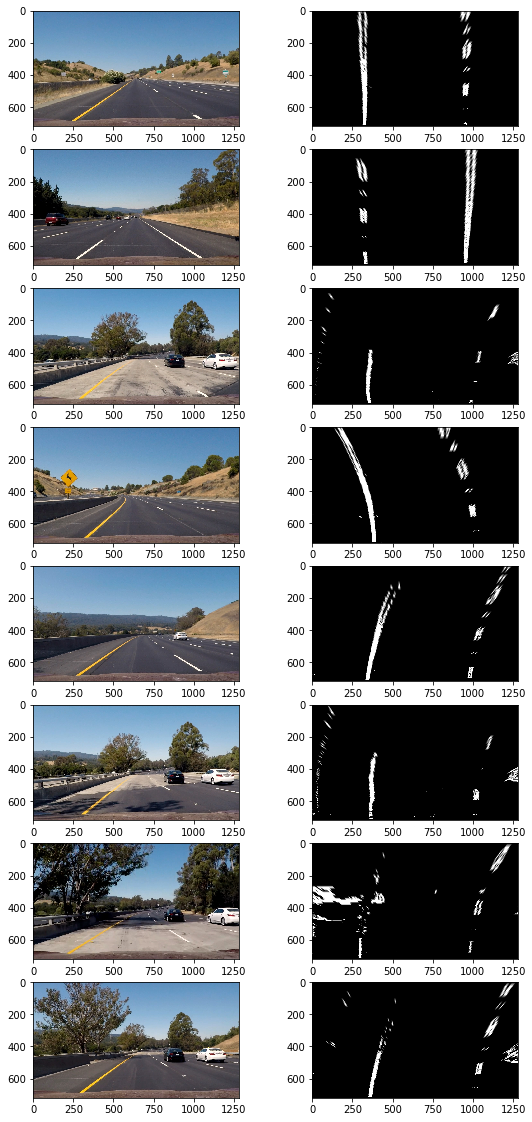

In [154]:
import glob
images =glob.glob('./test_images/*.jpg')

# plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    #img_test = cv2.imread(image)
    #img = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    img = mpimg.imread(image)
    warped, Minv = pipeline(img)
    axs[i].imshow(img)
    #axs[i].axis('off')
    i += 1
    axs[i].imshow(warped, cmap='gray')
    #axs[i].axis('off')
    i += 1

print('Done!')

In [13]:
img = mpimg.imread('./test_images/test4.jpg')
warped, Minv = pipeline(img)
plt.imshow(warped)
print(warped)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 5.Detect lane pixels and fit to find the lane boundary.


In [161]:
binary_warped = warped
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.show()

In [167]:
# Returns polyfit for left and right lanes. 
def sliding_window_polyfit(binary_warped, plot=True):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if plot == True:
        plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if plot == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    if left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty, left_fitx, right_fitx = generate_xy(binary_warped.shape[0], left_fit, right_fit)
        
        if plot:
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                          ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                          ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)

    return left_fit, right_fit 

def generate_xy(height, left_fit, right_fit):
    ploty = np.linspace(0, height-1, height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

In [200]:
#img = mpimg.imread('test_images/test5.jpg')
#warped, Minv = pipeline(img)
#left_fit, right_fit = sliding_window_polyfit(warped)

In [170]:
def polyfit_from_previous(binary_warped, left_fit_prev, right_fit_prev):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    #judge None or not 
    left_fit, right_fit = (None, None)
    if left_fit_prev is None or right_fit_prev is None:
        return left_fit, right_fit 
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    #if len(leftx) != 0:
    left_fit = np.polyfit(lefty, leftx, 2)
    #if len(rightx) != 0:
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

## 6.Determine the curvature of the lane and vehicle position with respect to center.

In [171]:
def curvature(width, ploty, left_fitx, right_fitx):
    # Compute curve radius    
    # Define conversions in x and y from pixels space to meters
    # 720 is length of the lane in perspective transformed image
    # 900 is approx. width of the lane in perspective transformed image
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    # Vehicle position estimate depends on the road curving left or right.
    # This is because the polynomial evaluation happens at the top of the images,
    # instead of the bottom of the screen (where the car is): instead of 0, some value near 720 (height) is be used.
    car_pos = width / 2
    lane_center = (left_fitx[719] + right_fitx[719]) / 2

    vehicle_offset = (lane_center-car_pos)*xm_per_pix
    
    # Now our radius of curvature is in meters
    radius_of_curvature = np.mean([left_curverad, right_curverad])
    return radius_of_curvature, vehicle_offset

## 7.Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [172]:
def draw_lane_area(undist, warped, Minv, left_fit, right_fit, show_curve_data=True):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = generate_xy_for_plotting(warped.shape[0], left_fit, right_fit)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(220,20,60), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(200,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if show_curve_data:
        font = cv2.FONT_HERSHEY_COMPLEX
        radius_of_curvature, vehicle_offset = curvature(warped.shape[1], ploty, left_fitx, right_fitx)
        cv2.putText(result, "Lane Curve Radius(m): ",(20,70), font, 2,(255,255,0),2, cv2.LINE_AA)
        cv2.putText(result, "{0:0.2f}".format(radius_of_curvature),(850,70), font, 2,(255,0,0),2, cv2.LINE_AA)
        
        cv2.putText(result, "Car offset(m):".format(vehicle_offset),(20,130), font, 2,(255,255,0),2, cv2.LINE_AA)
        cv2.putText(result, "{0:0.2f}".format(vehicle_offset),(550,130), font, 2,(255,0,0),2, cv2.LINE_AA)
    return result, left_fit, right_fit

In [183]:
def pipeline_all(img, left_fit_prev=None, right_fit_prev=None):
    warped, Minv= pipeline(img)
    left_fit, right_fit = polyfit_from_previous(warped, left_fit_prev, right_fit_prev)
    if left_fit is None or right_fit is None:
        left_fit, right_fit = sliding_window_polyfit(warped, plot=False)
    if left_fit is not None and right_fit is not None:
        return draw_lane_area(img, warped, Minv, left_fit, right_fit)
    return image, left_fit, right_fit

In [184]:
img = mpimg.imread('test_images/test6.jpg')
output,left_fit,right_fit= pipeline_all(img)
plt.imshow(output)

In [194]:
from moviepy.editor import VideoFileClip

class Lanes():
    def __init__(self):
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #left and right fit
        self.left_fit = None
        self.right_fit = None

def pipeline_video(input_path, output_path):
    #create an instance
    lanes = Lanes()
    video = VideoFileClip(input_path)
    
    def process_img(image):
        output, left_fit, right_fit = pipeline_all(image, lanes.left_fit, lanes.right_fit)
        lanes.left_fit = left_fit
        lanes.right_fit = right_fit
        return output

    clip = video.fl_image(process_img)
    clip.write_videofile(output_path, audio=False)

#output the videos
pipeline_video('project_video.mp4', 'output.mp4')

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



  8%|███▎                                      | 98/1261 [00:22<04:26,  4.36it/s]


 16%|██████▍                                  | 197/1261 [00:47<04:14,  4.18it/s]


 23%|█████████▌                               | 296/1261 [01:09<03:48,  4.23it/s]


 31%|████████████▊                            | 395/1261 [01:34<03:26,  4.19it/s]


 39%|████████████████                         | 494/1261 [01:58<03:04,  4.17it/s]


 47%|███████████████████▎                     | 593/1261 [02:24<02:43,  4.09it/s]


 55%|██████████████████████▍                  | 692/1261 [03:03<02:30,  3.78it/s]


 63%|█████████████████████████▋               | 791/1261 [03:44<02:13,  3.52it/s]


 71%|████████████████████████████▉            | 890/1261 [04:21<01:48,  3.41it/s]


 78%|████████████████████████████████▏        | 989/1261 [04:57<01:21,  3.32it/s]


 86%|██████████████████████████████████▌     | 1088/1261 [05:35<00:53,  3.24it/s]


 94%|█████████████████████████████████████▋  | 1187/1261 [06:15<00:23,  3.16it/s]


100%|███████████████████████████████████████▉| 1260/1261 [06:42<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [21]:
pipeline_video('challenge_video.mp4', 'challenge_output.mp4')

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████████████████████████████████████| 485/485 [01:27<00:00,  5.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 



In [22]:
pipeline_video('harder_challenge_video.mp4', 'harder_challenge_output.mp4')

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


100%|███████████████████████████████████████▉| 1199/1200 [04:01<00:00,  4.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

